In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pprint

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
%load_ext watermark
%watermark -iv -p sklearn

seaborn    0.9.0
numpy      1.15.4
scipy      1.2.0
pandas     0.24.0
matplotlib 3.0.2
sklearn 0.20.2


## Read in the data set

In [3]:
data = pd.read_pickle("../data/MERGED2016_17_select.pck")

In [4]:
data.shape

(1828, 44)

In [5]:
data.columns

Index(['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'RELAFFIL',
       'ADM_RATE', 'SAT_AVG', 'UGDS', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_NHPI',
       'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'PPTUG_EF', 'TUITIONFEE_IN',
       'TUITFTE', 'INEXPFTE', 'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF',
       'INSTNM', 'CITY', 'STABBR', 'ALIAS', 'INSTURL', 'ZIP', 'GRAD_DEBT_MDN',
       'BACH_ONLY', 'PUBLIC', 'PART_TIME_lower', 'PART_TIME_medium',
       'TRANSFERS_lower', 'INCLUSIVE_more_selective', 'INCLUSIVE_selective',
       'SIZECAT_medium', 'SIZECAT_small', 'SIZECAT_very_small',
       'RESIDENTIAL_nonresidential', 'RESIDENTIAL_residential'],
      dtype='object')

In [6]:
# these are just used to identify the colleges, but 
# not to predict debt
college_labels = ['INSTNM', 'CITY', 'STABBR', 'ALIAS',
                 'INSTURL', 'ZIP']
labels_data = data[college_labels]
data = data.drop(columns=college_labels)



In [7]:
predictors = [
       'ADM_RATE', 'SAT_AVG', 'UGDS', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_NHPI',
       'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'PPTUG_EF', 'TUITFTE', 'TUITIONFEE_IN', 'INEXPFTE',
       'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF' ] 

categorical_predictors = ['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'RELAFFIL',
       'BACH_ONLY', 'PUBLIC',
       'PART_TIME_lower', 'PART_TIME_medium', 'TRANSFERS_lower',
       'INCLUSIVE_more_selective', 'INCLUSIVE_selective', 'SIZECAT_medium',
       'SIZECAT_small', 'SIZECAT_very_small', 'RESIDENTIAL_nonresidential',
       'RESIDENTIAL_residential']

# Data cleaning 

## Remove NULLs from the numerical features

In [8]:
data[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1828 entries, 0 to 6734
Data columns (total 17 columns):
ADM_RATE         1560 non-null float64
SAT_AVG          1277 non-null float64
UGDS             1827 non-null float64
UGDS_WHITE       1827 non-null float64
UGDS_ASIAN       1827 non-null float64
UGDS_NHPI        1827 non-null float64
UGDS_2MOR        1827 non-null float64
UGDS_NRA         1827 non-null float64
UGDS_UNKN        1827 non-null float64
PPTUG_EF         1825 non-null float64
TUITFTE          1828 non-null float64
TUITIONFEE_IN    1763 non-null float64
INEXPFTE         1828 non-null float64
AVGFACSAL        1818 non-null float64
PFTFAC           1803 non-null float64
PCTPELL          1827 non-null float64
PFTFTUG1_EF      1758 non-null float64
dtypes: float64(17)
memory usage: 257.1 KB


In [9]:
def see_labels(datavec):
    return labels_data.loc[data.loc[datavec,:].index, :]

In [10]:
# cleaning up NULLs
# looks like only one school didn't report enrollment, just drop
miss_enrol = np.isnan(data.UGDS)
data = data.loc[~miss_enrol, :]

In [11]:
# these were both non-traditional colleges: an art school and a grad school
# not needed/wanted to make a general model
miss_pptug_ef = np.isnan(data.PPTUG_EF)
see_labels(miss_pptug_ef)

,INSTNM,CITY,STABBR,ALIAS,INSTURL,ZIP
1606,School of the Museum of Fine Arts at Tufts Uni...,Boston,MA,Museum School |SMFA |SMFA at Tufts,www.smfa.edu/,02115-5596
4964,Marlboro College Graduate & Professional Studies,Marlboro,VT,"Marlboro College, Marlboro College Grad School...",www.marlboro.edu/academics/graduate,05344


In [12]:
data = data.loc[~miss_pptug_ef, :]

miss_avgfacsal = np.isnan(data.AVGFACSAL)
data = data.loc[~miss_avgfacsal, :]

miss_ptef = np.isnan(data.PFTFTUG1_EF)
data = data.loc[~miss_ptef, :]

miss_pftfac = np.isnan(data.PFTFAC)
data = data.loc[~miss_pftfac, :]

miss_tuition = np.isnan(data.TUITIONFEE_IN)
data = data.loc[~miss_tuition, :]

In [13]:
# ADM_RATE and SAT_AVG are the only ones left, 
# drop SAT_AVG rather than guessing on a third of the data

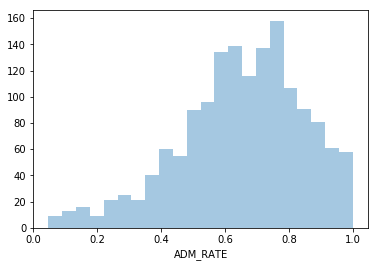

In [14]:
sns.distplot(data.ADM_RATE.dropna(), kde=False)

In [15]:
data.ADM_RATE.dropna().quantile(.75)

0.7877

In [16]:
data.ADM_RATE = data.ADM_RATE.fillna(.7877)

In [17]:
predictors.remove('SAT_AVG')
data = data.drop(columns='SAT_AVG')

In [18]:
data[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741 entries, 0 to 6734
Data columns (total 16 columns):
ADM_RATE         1741 non-null float64
UGDS             1741 non-null float64
UGDS_WHITE       1741 non-null float64
UGDS_ASIAN       1741 non-null float64
UGDS_NHPI        1741 non-null float64
UGDS_2MOR        1741 non-null float64
UGDS_NRA         1741 non-null float64
UGDS_UNKN        1741 non-null float64
PPTUG_EF         1741 non-null float64
TUITFTE          1741 non-null float64
TUITIONFEE_IN    1741 non-null float64
INEXPFTE         1741 non-null float64
AVGFACSAL        1741 non-null float64
PFTFAC           1741 non-null float64
PCTPELL          1741 non-null float64
PFTFTUG1_EF      1741 non-null float64
dtypes: float64(16)
memory usage: 231.2 KB


### Categorical columns

In [19]:
data[categorical_predictors].sum()

HBCU                            84.0
PBI                             31.0
ANNHI                           11.0
TRIBAL                           2.0
AANAPII                         62.0
HSI                            194.0
NANTI                           11.0
RELAFFIL                       637.0
BACH_ONLY                      405.0
PUBLIC                         646.0
PART_TIME_lower               1274.0
PART_TIME_medium               322.0
TRANSFERS_lower                574.0
INCLUSIVE_more_selective       409.0
INCLUSIVE_selective            609.0
SIZECAT_medium                 472.0
SIZECAT_small                  635.0
SIZECAT_very_small             351.0
RESIDENTIAL_nonresidential     531.0
RESIDENTIAL_residential        544.0
dtype: float64

In [20]:
# Let's merge native american non tribal, tribal, and pacific native
# together as indigenous-serving because there are so few
# and merge predominantly black and HBCU

In [21]:
data['BLACK'] = (data.HBCU + data.PBI).astype(int)
data['INDIG'] = (data.TRIBAL + data.AANAPII + data.NANTI + data.ANNHI).astype(int)
data = data.drop(columns=['HBCU', 'PBI', 'TRIBAL', 'AANAPII', 'NANTI', 'ANNHI', 'UGDS_NHPI'])

# somebody checked off both HBCU and Predominantly Black
data.loc[data.eval('BLACK > 1'), 'BLACK'] = 1

In [22]:
categorical_predictors.remove('HBCU')
categorical_predictors.remove('PBI')
categorical_predictors.remove('TRIBAL')
categorical_predictors.remove('AANAPII')
categorical_predictors.remove('NANTI')
categorical_predictors.remove('ANNHI')
predictors.remove('UGDS_NHPI')
categorical_predictors += ['BLACK', 'INDIG']

# make sure I've cleaned up collinear features

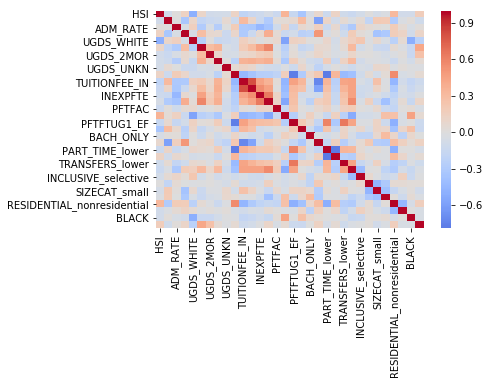

In [23]:
corr = data.corr()
sns.heatmap(data.corr(), center=0, cmap='coolwarm')

In [24]:
for i in corr.columns:
    for j in corr.columns:
        if corr.loc[i,j] > .7 and i > j: 
            print(i,j, corr.loc[i,j])

TUITIONFEE_IN TUITFTE 0.8161800403340566


In [25]:
data['COST'] = data.eval('TUITFTE + TUITIONFEE_IN')
data = data.drop(columns=['TUITFTE', 'TUITIONFEE_IN'])

In [26]:
predictors.remove('TUITFTE')
predictors.remove('TUITIONFEE_IN')
predictors.append('COST')

## Setting up modeling

In [27]:
# scale all the numerical predictors
data[predictors].describe()

,ADM_RATE,UGDS,UGDS_WHITE,UGDS_ASIAN,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,INEXPFTE,AVGFACSAL,PFTFAC,PCTPELL,PFTFTUG1_EF,COST
count,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.00000,1741.000000,1741.000000,1741.000000,1741.000000
mean,0.667464,5129.614589,0.563671,0.041202,0.032991,0.040572,0.041495,0.148977,10443.411832,7563.71166,0.671306,0.379446,0.682737,34614.769098
std,0.188556,7331.113677,0.241366,0.057662,0.027485,0.053102,0.056840,0.162052,9151.433062,2342.50622,0.255112,0.168205,0.205320,20852.737726
min,0.048100,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,452.000000,960.00000,0.038500,0.000000,0.002600,1766.000000
25%,0.556000,1090.000000,0.445800,0.009700,0.018800,0.008500,0.008600,0.035600,6378.000000,6025.00000,0.479900,0.264300,0.571000,16307.000000
50%,0.703900,2189.000000,0.627800,0.020600,0.029300,0.022300,0.024900,0.097300,8531.000000,7254.00000,0.676200,0.358000,0.710900,31819.000000
75%,0.787700,5631.000000,0.748300,0.045100,0.041200,0.051300,0.052700,0.202500,11573.000000,8840.00000,0.924400,0.463300,0.836800,48067.000000
max,1.000000,55113.000000,0.962000,0.470700,0.362300,0.552500,0.603200,0.954700,147063.000000,22146.00000,1.000000,0.958400,1.000000,155049.000000


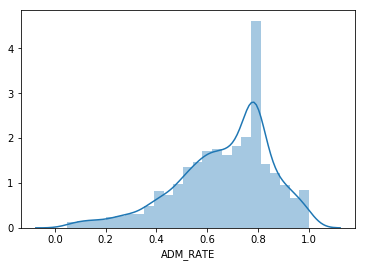

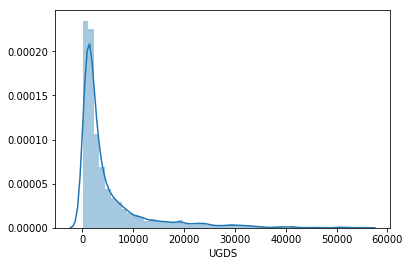

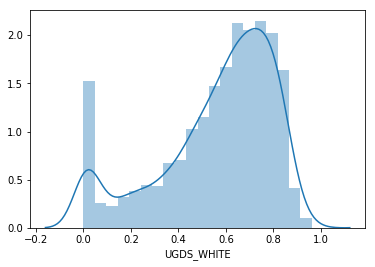

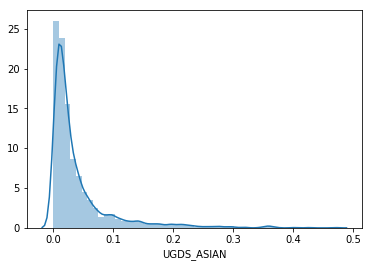

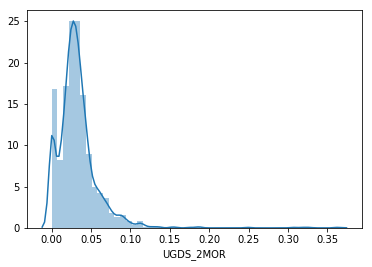

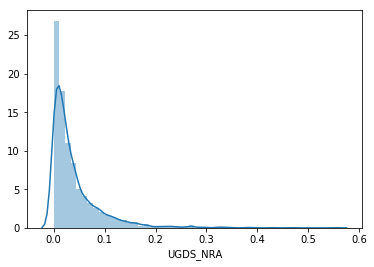

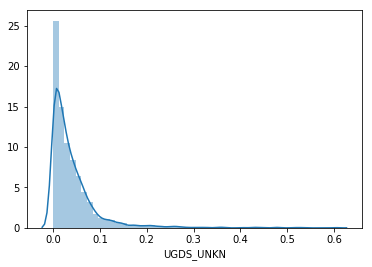

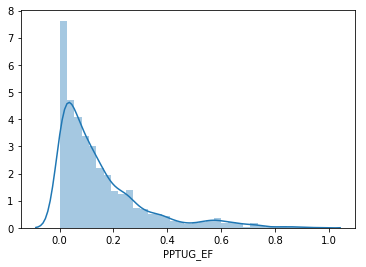

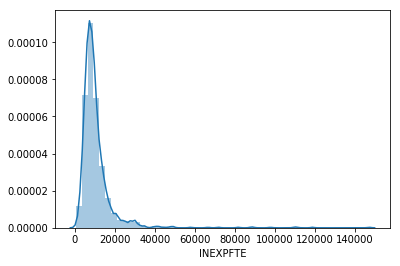

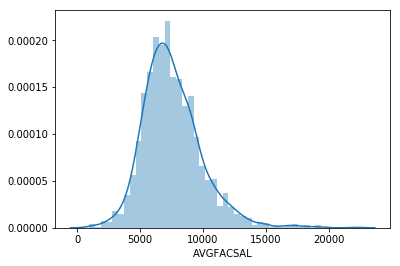

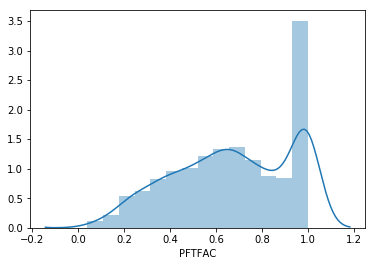

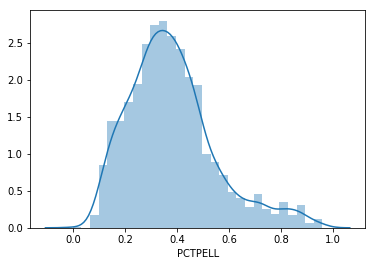

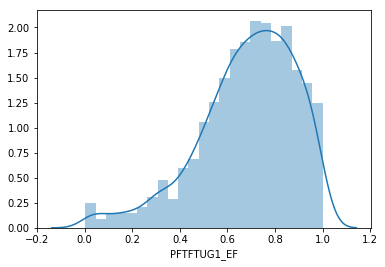

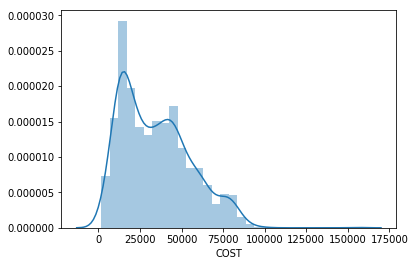

In [28]:
for col in predictors:
    sns.distplot(data[col])
    plt.show()

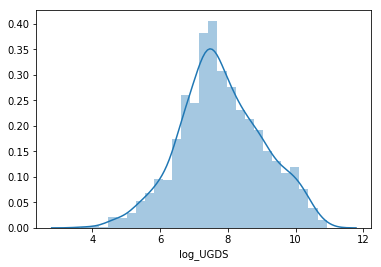

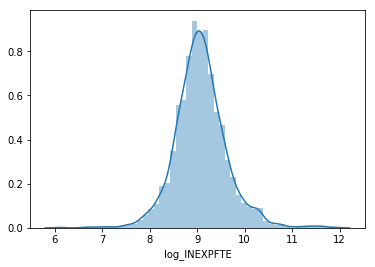

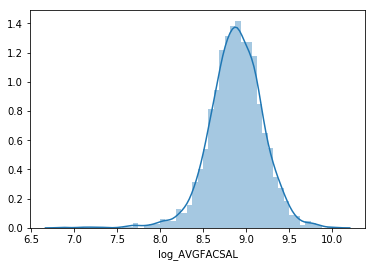

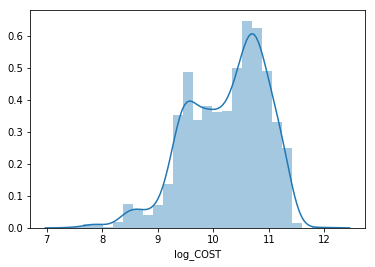

In [29]:
# log the "spiky ones"
data['log_UGDS'] = np.log(data.UGDS)
data['log_INEXPFTE'] = np.log(data.INEXPFTE)
data['log_AVGFACSAL'] = np.log(data.AVGFACSAL)
data['log_COST'] = np.log(data.COST)
newcols =  ['log_UGDS', 'log_INEXPFTE', 'log_AVGFACSAL', 'log_COST']
for col in newcols:
    sns.distplot(data[col])
    plt.show()
predictors.remove('UGDS')
predictors.remove('INEXPFTE')
predictors.remove('AVGFACSAL')
predictors.remove('COST')
predictors += newcols


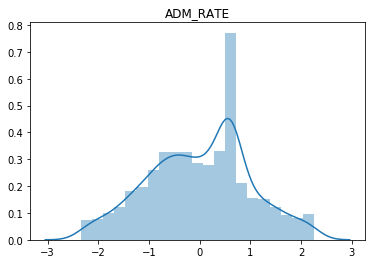

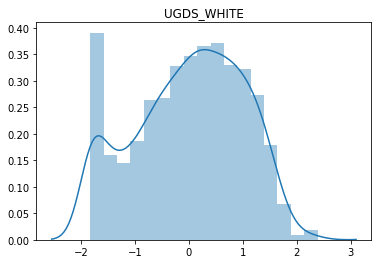

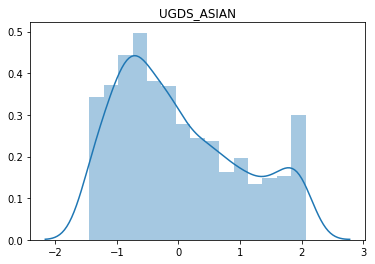

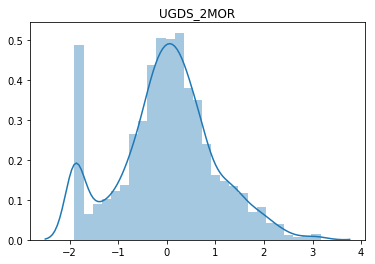

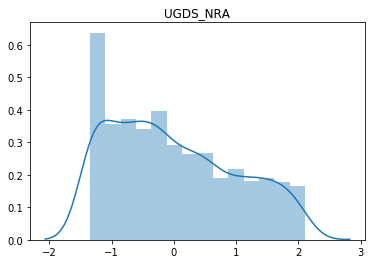

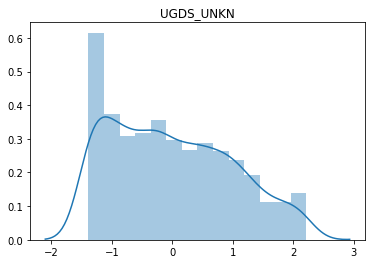

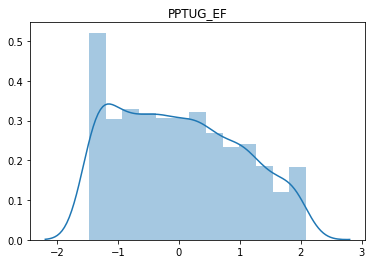

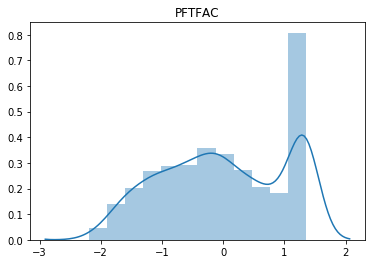

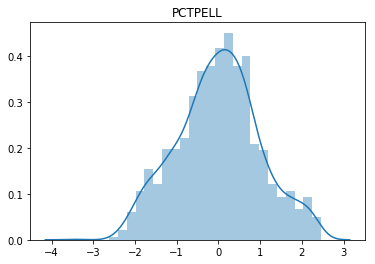

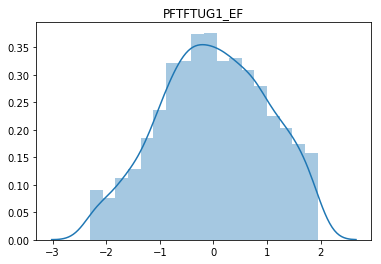

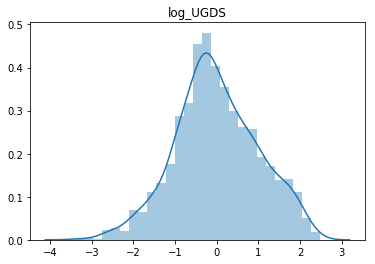

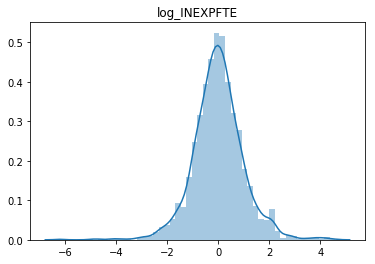

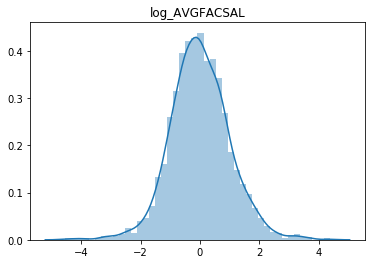

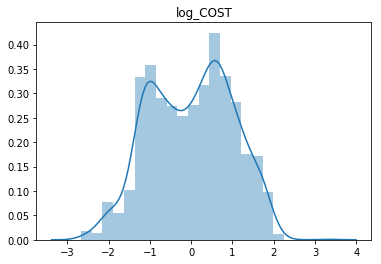

In [30]:
## make sure it all scales nice
ss = PowerTransformer()
for col in predictors:
    x = ss.fit_transform(data[col].values.reshape(-1,1))
    sns.distplot(x)
    plt.title(col)
    plt.show()

### Train_test_split

In [31]:
y =  data['GRAD_DEBT_MDN']
X = data.drop(columns='GRAD_DEBT_MDN')
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.25, random_state=42)

In [32]:
X_train.shape

(1305, 34)

In [33]:
X_test.shape

(436, 34)

In [34]:
y_train.shape

(1305,)

In [35]:
y_test.shape

(436,)

In [36]:
ptscale = PowerTransformer()
X_train_scaled = ptscale.fit_transform(X_train[predictors])
X_test_scaled = ptscale.transform(X_test[predictors])

In [37]:
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=predictors, index=X_train.index)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=predictors, index=X_test.index)

X_train_scaled = pd.concat([X_train_scaled,X_train[categorical_predictors]], axis=1)
X_test_scaled = pd.concat([X_test_scaled,X_test[categorical_predictors]], axis=1)

In [38]:
# create an interaction term COST * PUBLIC because the cost distplots have a distinct
# two-hump pattern matching public/private having separate cost distributions

X_train_scaled['log_COST_PUBLIC'] = X_train_scaled.log_COST * X_train_scaled.PUBLIC
X_test_scaled['log_COST_PUBLIC'] = X_test_scaled.log_COST * X_test_scaled.PUBLIC

In [39]:
predictors += ['log_COST_PUBLIC']

# Modeling 

## Ridge 

In [40]:
pipe = make_pipeline(
    Ridge()
)

params = {
    'ridge__alpha':[ 1.9, 1.93, 1.95, 1.97, 2, 2.05,  ] 
}

search = GridSearchCV(pipe, param_grid=params, cv=4, scoring='r2') 
result = search.fit(X_train_scaled, y_train)

In [41]:
result.best_params_

{'ridge__alpha': 1.97}

In [42]:
result.best_score_

0.5100659162707688

In [43]:
yhat = search.predict(X_test_scaled)
r2 = r2_score(y_test, yhat)
r2

0.4731027178447106

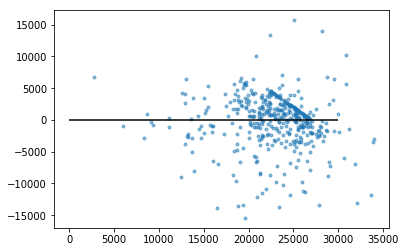

In [44]:
plt.scatter(yhat, y_test-yhat, marker='.', alpha=0.5)
plt.hlines(0,0,30000)

ADM_RATE


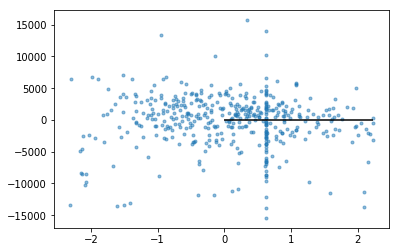

UGDS_WHITE


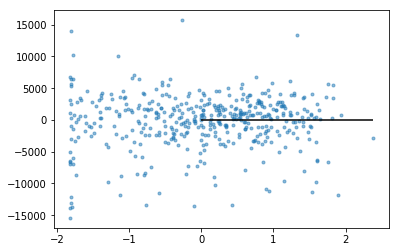

UGDS_ASIAN


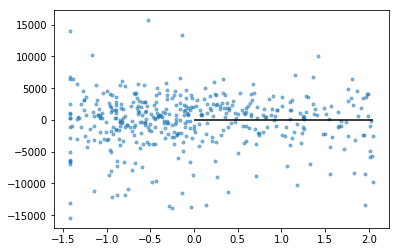

UGDS_2MOR


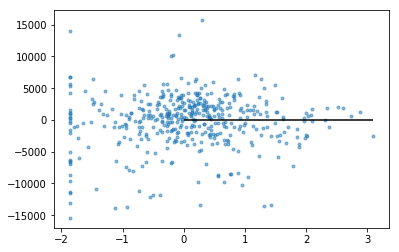

UGDS_NRA


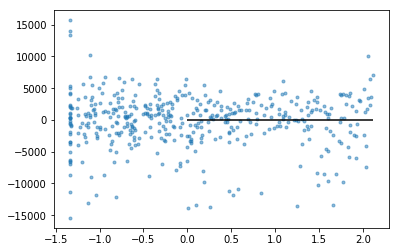

UGDS_UNKN


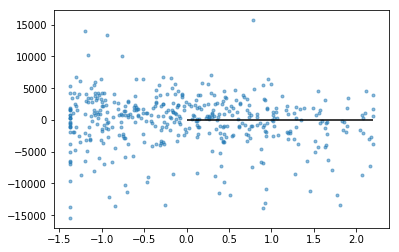

PPTUG_EF


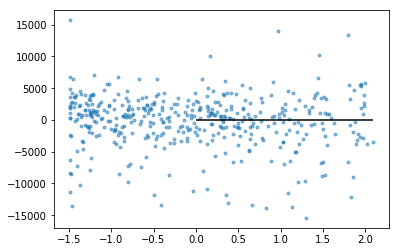

PFTFAC


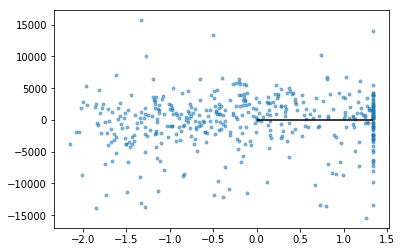

PCTPELL


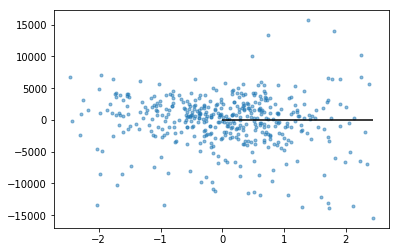

PFTFTUG1_EF


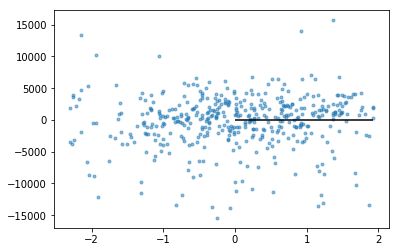

log_UGDS


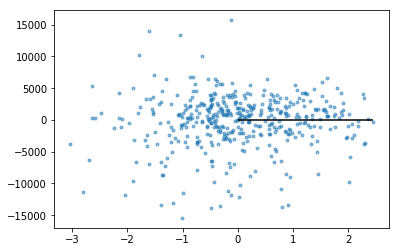

log_INEXPFTE


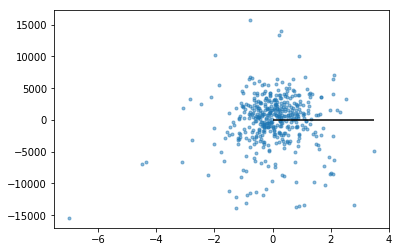

log_AVGFACSAL


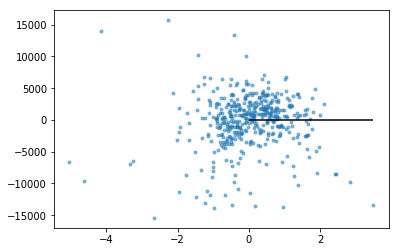

log_COST


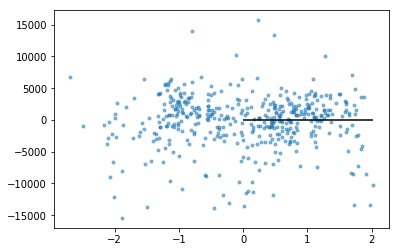

log_COST_PUBLIC


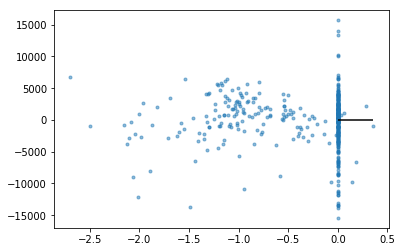

In [45]:
for c in predictors:
    print(c)
    plt.scatter(X_test_scaled[c], y_test - yhat, 
                marker=".", alpha=0.5)
    plt.hlines(0,0,X_test_scaled[c].max())
    plt.show()


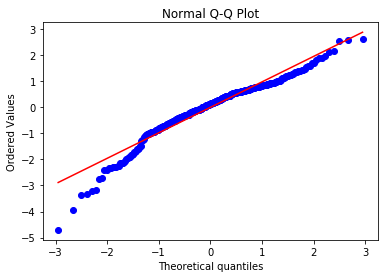

In [46]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm", plot=plt)
fig = plt.get_current_fig_manager()
plt.title("Normal Q-Q Plot")
plt.show()

## Lasso

In [47]:
pipe = make_pipeline(
    Lasso()
)

params = {
    'lasso__alpha':list( np.arange(20., 25., .25) )
}

search = GridSearchCV(pipe, param_grid=params, cv=4, scoring='r2') 
result = search.fit(X_train_scaled, y_train)

In [48]:
result.best_params_

{'lasso__alpha': 22.5}

In [49]:
result.best_score_

0.5126757325636638

In [50]:
yhat = search.predict(X_test_scaled)
r2 = r2_score(y_test, yhat)
r2

0.47138042381771306

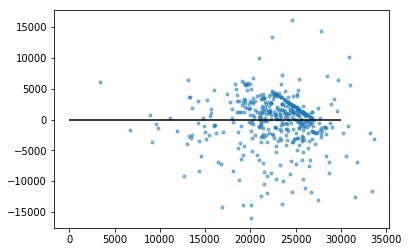

In [51]:
plt.scatter(yhat, y_test-yhat, marker='.', alpha=0.5)
plt.hlines(0,0,30000)

ADM_RATE


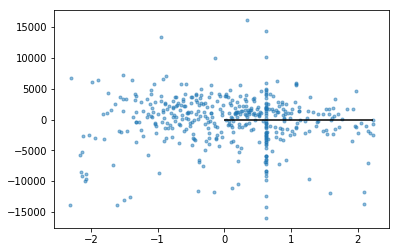

UGDS_WHITE


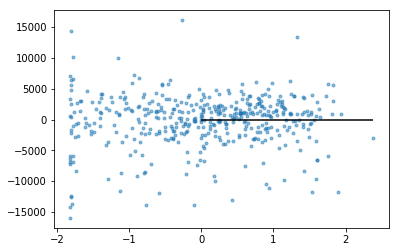

UGDS_ASIAN


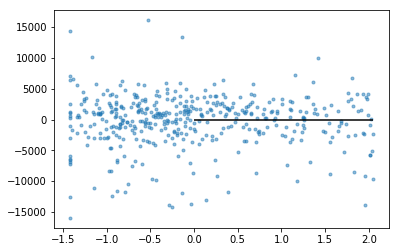

UGDS_2MOR


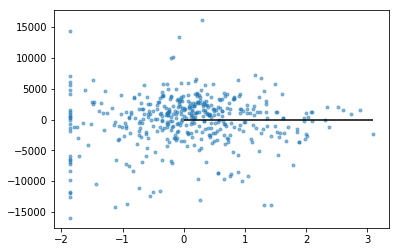

UGDS_NRA


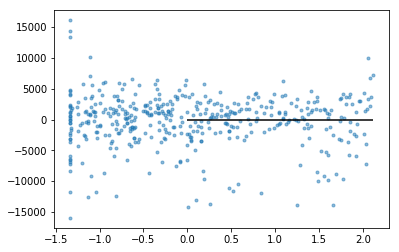

UGDS_UNKN


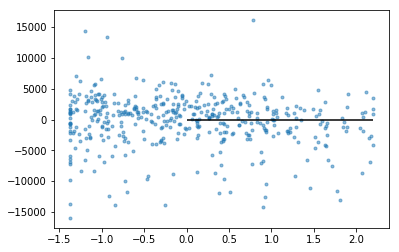

PPTUG_EF


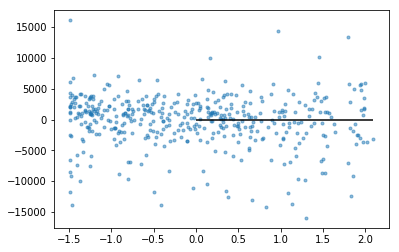

PFTFAC


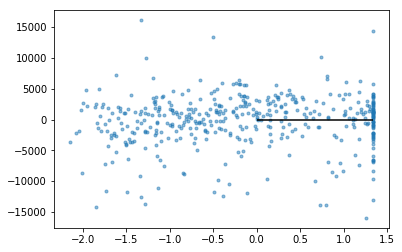

PCTPELL


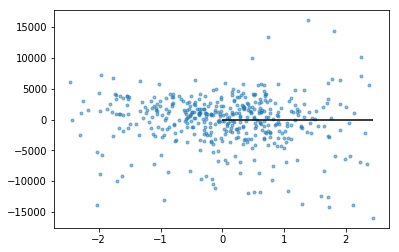

PFTFTUG1_EF


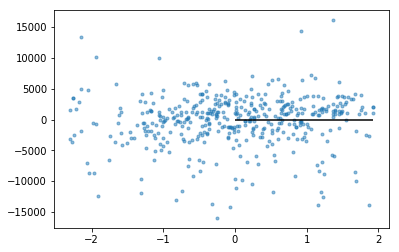

log_UGDS


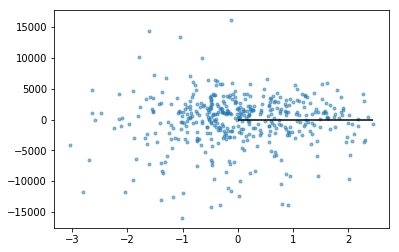

log_INEXPFTE


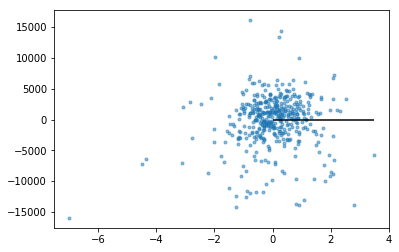

log_AVGFACSAL


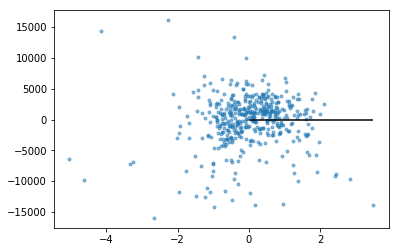

log_COST


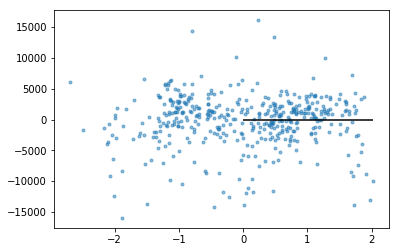

log_COST_PUBLIC


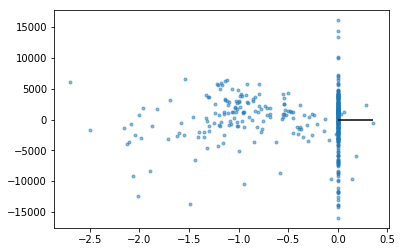

In [52]:
for c in predictors:
    print(c)
    plt.scatter(X_test_scaled[c], y_test - yhat, 
                marker=".", alpha=0.5)
    plt.hlines(0,0,X_test_scaled[c].max())
    plt.show()


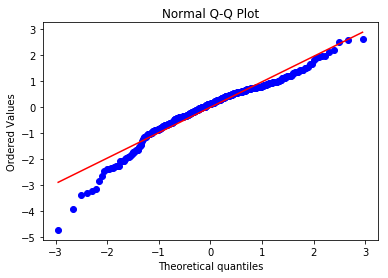

In [53]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm", plot=plt)
fig = plt.get_current_fig_manager()
plt.title("Normal Q-Q Plot")
plt.show()